In [ ]:
!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets

     |████████████████████████████████| 1.3 MB 34.1 MB/s 
     |████████████████████████████████| 3.3 MB 31.6 MB/s 
     |████████████████████████████████| 34.5 MB 15 kB/s 
     |████████████████████████████████| 462 kB 72.8 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [ ]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_dataset('cifar10')

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 30000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [ ]:
y_temp=[]
for i in range(len(y_raw)):
  for j in range(len(y_raw[i])):
    if y_raw[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw=y_temp

In [ ]:
y_temp=[]
for i in range(len(y_raw_test)):
  for j in range(len(y_raw_test[i])):
    if y_raw_test[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw_test=y_temp

In [ ]:
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [ ]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    print(x_clean.shape,"x_clean shape")
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]
        print(src_imgs.shape,"src images shape")

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        print(imgs_to_be_poisoned.shape,"imgs to be poisoned shape")
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    print(x_poison.shape,"x poison shape")
    return is_poison, x_poison, y_poison

In [ ]:
# Poison training data
percent_poison = .1
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
#x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
#x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

(30000, 32, 32, 3) x_clean shape
(3126, 32, 32, 3) src images shape
(333, 32, 32, 3) imgs to be poisoned shape
(2996, 32, 32, 3) src images shape
(322, 32, 32, 3) imgs to be poisoned shape
(2896, 32, 32, 3) src images shape
(326, 32, 32, 3) imgs to be poisoned shape
(2932, 32, 32, 3) src images shape
(339, 32, 32, 3) imgs to be poisoned shape
(3047, 32, 32, 3) src images shape
(331, 32, 32, 3) imgs to be poisoned shape
(2980, 32, 32, 3) src images shape
(343, 32, 32, 3) imgs to be poisoned shape
(3091, 32, 32, 3) src images shape
(330, 32, 32, 3) imgs to be poisoned shape
(2971, 32, 32, 3) src images shape
(330, 32, 32, 3) imgs to be poisoned shape
(2969, 32, 32, 3) src images shape
(332, 32, 32, 3) imgs to be poisoned shape
(2992, 32, 32, 3) src images shape
(347, 32, 32, 3) imgs to be poisoned shape
(33333, 32, 32, 3) x poison shape
(10000, 32, 32, 3) x_clean shape
(1000, 32, 32, 3) src images shape
(111, 32, 32, 3) imgs to be poisoned shape
(1000, 32, 32, 3) src images shape
(111, 3

In [ ]:
print(x_test.shape)

(11110, 32, 32, 3)


In [ ]:
print(y_test.shape)

(11110, 10)


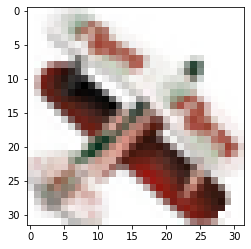

In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays
c_idx=25
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()

In [ ]:
print(len(poison_x_test))

1110


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np

from art.attacks.evasion import DeepFool
from art.estimators.classification import KerasClassifier
from art.utils import load_dataset

In [ ]:
print(len(x_train))

33333


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:

warnings.filterwarnings('ignore')

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent import ProjectedGradientDescent
robust_classifier = KerasClassifier(model)

In [ ]:
attacks = ProjectedGradientDescent(robust_classifier, eps=0.3, eps_step=0.01, max_iter=5)

In [ ]:
trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
trainer.fit(x_train, y_train, nb_epochs=40, batch_size=1024)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
robust_classifier.save('/content/badnet_cifar_at.h5')

In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(robust_classifier.predict(poison_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i]+1)%10
  if poison_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(poison_preds))
print(100*ct/len(poison_preds)," % accuracy")

594
1110
53.513513513513516  % accuracy


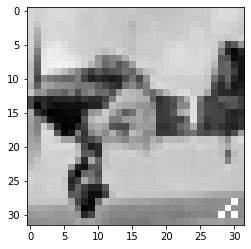

Prediction: 0

 Effectiveness of poison: 5.50%


In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(robust_classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

c = 1 # class to display
i = 0 # image of the class to display

c_idx = 43

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

10000

Clean test set accuracy: 51.99%


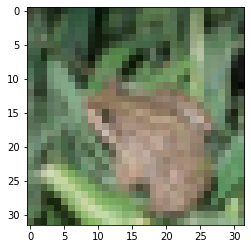

Prediction: 6
Clean Label: 6


In [ ]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]
clean_temp=[]
for i in range(len(clean_y_test)):
  for j in range(10):
    if clean_y_test[i][j]==1:
      clean_temp.append(j)
print(len(clean_x_test))
clean_preds = np.argmax(robust_classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = 4

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))
print("Clean Label: " + str(clean_temp[c_idx]))

In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]
poison_temp=[]
for i in range(len(poison_y_test)):
  for j in range(10):
    if poison_y_test[i][j]==1:
      poison_temp.append((j-1+10)%10)
poison_preds = np.argmax(robust_classifier.predict(poison_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i]+1)%10
  if poison_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(poison_preds))
print(100*ct/len(poison_preds)," % accuracy")

594
1110
53.513513513513516  % accuracy


In [ ]:
for i in range(len(poison_preds)):
  jhc=(poison_preds[i]+1)%10
  if poison_y_test[i][jhc]==1:
    print(i)

0
1
2
5
8
11
13
15
16
18
19
21
22
24
25
27
28
30
31
32
33
34
35
36
40
43
44
45
46
47
50
51
53
54
55
56
60
62
64
66
67
69
70
76
77
78
79
80
81
82
84
86
88
89
90
91
95
96
97
99
100
103
109
110
111
112
113
115
116
117
119
120
122
124
125
127
129
130
131
132
133
135
136
137
138
140
141
142
143
144
145
147
148
150
151
152
154
155
156
157
158
159
161
162
163
164
165
166
167
170
171
173
174
175
176
178
179
180
182
183
184
186
187
188
189
190
192
194
195
196
197
199
201
202
203
204
205
206
207
208
210
213
214
215
216
217
219
231
233
235
236
237
249
251
253
262
273
274
276
277
280
281
286
310
314
330
332
338
339
346
349
354
356
359
362
370
371
372
376
377
380
383
384
385
393
395
400
410
415
421
422
429
444
445
447
448
454
456
459
464
465
467
468
470
472
478
482
484
485
488
490
491
494
496
497
498
503
505
508
509
511
512
517
520
521
525
529
530
532
534
536
537
543
545
548
550
551
552
553
556
557
558
559
560
561
564
569
574
576
578
579
582
585
587
590
592
597
600
602
603
606
607
610
612
614
616
6

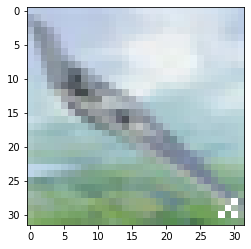

Prediction: airplane
Clean Label: airplane


In [ ]:
c_idx = 0

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

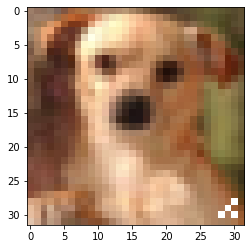

Prediction: dog
Clean Label: dog


In [ ]:
c_idx = 559

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

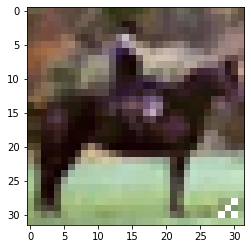

Prediction: horse
Clean Label: horse


In [ ]:
c_idx = 850

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

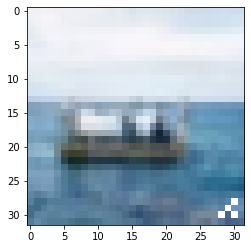

Prediction: ship
Clean Label: ship


In [ ]:
c_idx = 982

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

In [ ]:
temp_model=KerasClassifier(model)

In [ ]:
temp_model.fit(x_train,y_train)

Train on 33333 samples
Epoch 1/20
33333/33333 [==============================] - 4s 114us/sample - loss: 1.4378 - accuracy: 0.4990
Epoch 2/20
33333/33333 [==============================] - 3s 103us/sample - loss: 1.2674 - accuracy: 0.5646
Epoch 3/20
33333/33333 [==============================] - 3s 103us/sample - loss: 1.1751 - accuracy: 0.6022
Epoch 4/20
33333/33333 [==============================] - 3s 103us/sample - loss: 1.1012 - accuracy: 0.6266
Epoch 5/20
33333/33333 [==============================] - 3s 103us/sample - loss: 1.0343 - accuracy: 0.6431
Epoch 6/20
33333/33333 [==============================] - 3s 104us/sample - loss: 0.9385 - accuracy: 0.6685
Epoch 7/20
33333/33333 [==============================] - 3s 103us/sample - loss: 0.8489 - accuracy: 0.6999
Epoch 8/20
33333/33333 [==============================] - 3s 103us/sample - loss: 0.7967 - accuracy: 0.7203
Epoch 9/20
33333/33333 [==============================] - 3s 103us/sample - loss: 0.7504 - accuracy: 0.7356
Epoch

In [ ]:
poison_preds = np.argmax(temp_model.predict(poison_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i]+1)%10
  if poison_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(poison_preds))
print(100*ct/len(poison_preds)," % accuracy")

122
1110
10.99099099099099  % accuracy


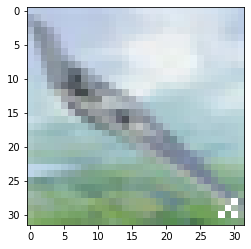

Prediction: automobile
Clean Label: airplane


In [ ]:
c_idx = 0

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

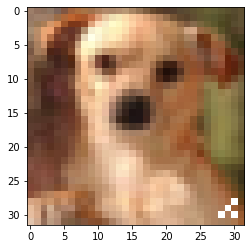

Prediction: frog
Clean Label: dog


In [ ]:
c_idx = 559

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

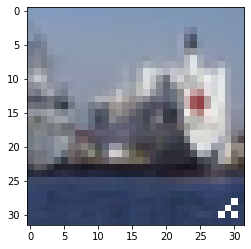

Prediction: truck
Clean Label: ship


In [ ]:
c_idx = 924

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

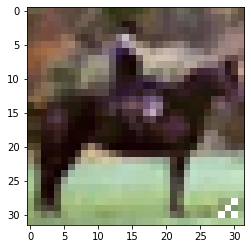

Prediction: ship
Clean Label: horse


In [ ]:
c_idx = 850

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

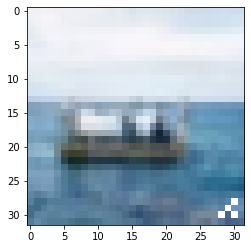

Prediction: truck
Clean Label: ship


In [ ]:
c_idx = 982

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(class_descr[poison_preds[c_idx]]))
print("Clean Label: " + str(class_descr[poison_temp[c_idx]]))

In [ ]:
print('anubhav')

anubhav


In [ ]:
temp_model.save('/content/badnet_cifar_normal.h5')

In [ ]:
from keras.models import load_model
kal_model = load_model('/content/badnet_cifar_at.h5')

10000

Clean test set accuracy: 51.99%


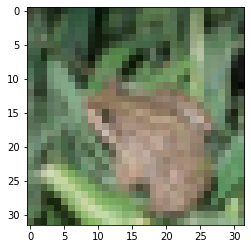

Prediction: 6
Clean Label: 6


In [ ]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]
clean_temp=[]
for i in range(len(clean_y_test)):
  for j in range(10):
    if clean_y_test[i][j]==1:
      clean_temp.append(j)
print(len(clean_x_test))
clean_preds = np.argmax(kal_model.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = 4

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))
print("Clean Label: " + str(clean_temp[c_idx]))

In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]
poison_temp=[]
for i in range(len(poison_y_test)):
  for j in range(10):
    if poison_y_test[i][j]==1:
      poison_temp.append((j-1+10)%10)
poison_preds = np.argmax(kal_model.predict(poison_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i]+1)%10
  if poison_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(poison_preds))
print(100*ct/len(poison_preds)," % accuracy")

594
1110
53.513513513513516  % accuracy
